## Calculate perihelion distances of Oort Cloud particles

This notebook allows you to calculate the perihelion distances of Oort Cloud particles before and after the perturbation of HD7977 using impulse approximation.

You can change "b" value to change the closest passing distance.

In [41]:
import numpy as np
import matplotlib.pyplot as plt
import rebound
from rebound.tools import M_to_f

In [42]:
def rotation_matrix_to_target(v1, target):
    # Normalize input vectors
    v1 = np.array(v1, dtype=np.float64)
    target = np.array(target, dtype=np.float64)
    v1 = v1 / np.linalg.norm(v1)
    target = target / np.linalg.norm(target)
    
    # Compute cross product and sine of angle
    axis = np.cross(v1, target)
    sin_theta = np.linalg.norm(axis)
    
    # Compute dot product and cosine of angle
    cos_theta = np.dot(v1, target)
    
    # If the vectors are already aligned
    if sin_theta == 0 and cos_theta > 0:
        return np.eye(3)
    
    # If the vectors are opposite
    if sin_theta == 0 and cos_theta < 0:
        # Return a rotation of 180 degrees around an orthogonal vector
        # Find an orthogonal vector
        orthogonal = np.array([1, 0, 0]) if abs(v1[0]) < abs(v1[1]) else np.array([0, 1, 0])
        axis = np.cross(v1, orthogonal)
        axis = axis / np.linalg.norm(axis)
        K = np.array([
            [0, -axis[2], axis[1]],
            [axis[2], 0, -axis[0]],
            [-axis[1], axis[0], 0]
        ])
        return np.eye(3) + K + K @ K
    
    # Normalize the axis
    axis = axis / sin_theta
    
    # Compute the skew-symmetric cross-product matrix of the axis
    K = np.array([
        [0, -axis[2], axis[1]],
        [axis[2], 0, -axis[0]],
        [-axis[1], axis[0], 0]
    ])
    
    # Compute the rotation matrix
    R = np.eye(3) + np.sin(np.arcsin(sin_theta)) * K + (1 - cos_theta) * (K @ K)
    return R



In [43]:
# Set the units
sim = rebound.Simulation()
sim.units = ('yr', 'AU', 'Msun')
G = sim.G

# The Sun
M = 1 # Msun

# HD 7977
v0 = 26.4485 # km/s
v_vector = np.array([11.67373463, 13.27281649, 19.67970122]) # km/s, calculated from the radial velocity and proper motion
km_to_au = 1 / 149597870.7
s_to_year = 31557600
conversion_factor = km_to_au * s_to_year
vp = v0 * conversion_factor
Mp = 1.07 # Msun
bp = 2300  # AU, also has other data says 37380.51 AU

N_sim_points = 1000000

# Set the inner Oort Cloud
a = 10**np.random.uniform(np.log10(2000), np.log10(20000), N_sim_points)
e2 = np.random.uniform(0, 1, N_sim_points)
e = np.sqrt(e2)
q = a * (1 - e)

# filter with q > 10 AU
initial_filter = q > 10
a = a[initial_filter]
e = e[initial_filter]
q = q[initial_filter]
N_sim_points = len(a)

phi = np.random.uniform(0, 2 * np.pi, N_sim_points) # orientation of the ellipse, also the argument of pericenter (omega)

M_ = np.random.uniform(0, 2 * np.pi, N_sim_points) # mean anomaly
f = np.array([M_to_f(e[i], M_[i]) for i in range(N_sim_points)])  # true anomaly

alpha = phi + f  # angle from the x-axis to the position vector
Omega = np.random.uniform(0, 2 * np.pi, N_sim_points)  # longitude of the ascending node

inc = np.where(a > 5000, np.arccos(np.random.uniform(-1, 1, N_sim_points)), 
        np.random.normal(np.pi/6, np.pi/18, N_sim_points))  # inclination

c = a * e  # distance from the center to the focus
b = np.sqrt(a**2 - c**2)  # semi-minor axis


In [44]:
r = a * (1 - e**2) / (1 + e * np.cos(f))

tan_theta_phi = -b**2 / a**2 * (c + r * np.cos(f)) / (r * np.sin(f))
theta = np.where(np.array(f) < np.pi, np.arctan(tan_theta_phi) + phi + np.pi, np.arctan(tan_theta_phi) + phi)
v_in0 = np.sqrt(G * M * (2 / r - 1 / a))

Zero = np.zeros(N_sim_points)
r_0 = np.array([r * np.cos(alpha), r * np.sin(alpha), Zero])
v_0 = np.array([v_in0 * np.cos(theta), v_in0 * np.sin(theta), Zero])

# semi-minor axis : (a1,a2,a3)
a1 = -np.sin(phi) 
a2 = np.cos(phi)
a3 = np.zeros(N_sim_points)
aa = np.array([a1, a2, a3])

# rotation matrix
MM = np.array([
    [np.cos(inc) + (1 - np.cos(inc)) * a1**2, (1 - np.cos(inc)) * a1 * a2 - np.sin(inc) * a3, (1 - np.cos(inc)) * a1 * a3 + np.sin(inc) * a2],
    [(1 - np.cos(inc)) * a1 * a2 + np.sin(inc) * a3, np.cos(inc) + (1 - np.cos(inc)) * a2**2, (1 - np.cos(inc)) * a2 * a3 - np.sin(inc) * a1],
    [(1 - np.cos(inc)) * a1 * a3 - np.sin(inc) * a2, (1 - np.cos(inc)) * a2 * a3 + np.sin(inc) * a1, np.cos(inc) + (1 - np.cos(inc)) * a3**2]
])

r_1 = np.einsum('ijk,jk->ik', MM, r_0)
v_1 = np.einsum('ijk,jk->ik', MM, v_0)

# normal vector
dd = np.cross(r_1, v_1, axis=0)
dd = dd / np.sqrt(dd[0]**2 + dd[1]**2 + dd[2]**2)
d1 = dd[0]
d2 = dd[1]
d3 = dd[2]

NN = np.array([
    [np.cos(Omega) + (1 - np.cos(Omega)) * d1**2, (1 - np.cos(Omega)) * d1 * d2 - np.sin(Omega) * d3, (1 - np.cos(Omega)) * d1 * d3 + np.sin(Omega) * d2],
    [(1 - np.cos(Omega)) * d1 * d2 + np.sin(Omega) * d3, np.cos(Omega) + (1 - np.cos(Omega)) * d2**2, (1 - np.cos(Omega)) * d2 * d3 - np.sin(Omega) * d1],
    [(1 - np.cos(Omega)) * d1 * d3 - np.sin(Omega) * d2, (1 - np.cos(Omega)) * d2 * d3 + np.sin(Omega) * d1, np.cos(Omega) + (1 - np.cos(Omega)) * d3**2]
])

r_1 = np.einsum('ijk,jk->ik', NN, r_1)
v_1 = np.einsum('ijk,jk->ik', NN, v_1)

r_in = np.sqrt(r_1[0]**2 + r_1[1]**2 + r_1[2]**2)
v_in = np.sqrt(v_1[0]**2 + v_1[1]**2 + v_1[2]**2)

RR = rotation_matrix_to_target(v_vector, [0, 1, 0])
r_1 = RR @ r_1
v_1 = RR @ v_1


E = -G * M / r_in + 0.5 * v_in**2

delta_v_x = 2 * G * Mp * (bp - r_1[0]) / vp / ((bp - r_1[0])**2 + (r_1[2])**2)
delta_v_y = np.zeros(N_sim_points)
delta_v_z = - 2 * G * Mp * r_1[2] / vp / ((bp - r_1[0])**2 + (r_1[2])**2)

delta_vx_sun = 2 * G * Mp / vp / bp
delta_vy_sun = 0    
delta_vz_sun = 0

delta_v_x = delta_v_x - delta_vx_sun
delta_v_y = delta_v_y - delta_vy_sun
delta_v_z = delta_v_z - delta_vz_sun

# delta_v_x = np.zeros(N_sim_points)
# delta_v_y = np.zeros(N_sim_points)
# delta_v_z = np.zeros(N_sim_points)


delta_v = np.array([delta_v_x, delta_v_y, delta_v_z])


v_after = v_1 + delta_v

E_after = -G * M / r_in + 0.5 * v_after[0]**2 + 0.5 * v_after[1]**2 + 0.5 * v_after[2]**2
v_1AU = np.sqrt(2 * (E_after + G * M / 1))

a_after = -G * M / 2 / E_after

ang_mom_after = np.cross(r_1, v_after, axis=0)
ang_mom_after = np.sqrt(ang_mom_after[0]**2 + ang_mom_after[1]**2 + ang_mom_after[2]**2)

e_after = np.sqrt(1 - ang_mom_after**2 / (G * M * a_after))
perihelion = ang_mom_after**2 / ((e_after + 1) * G * M)

print('v_1AU:', v_1AU[perihelion < 1].mean())


v_1AU: 8.885192271234944


Number of particles that get into 1 AU: 184 in 996032 particles
Percentage of particles that get into 1 AU: 0.018473302062584334%
Number of particles that get into 1 AU: 0 in 996032 particles
Percentage of particles that get into 1 AU: 0.0%


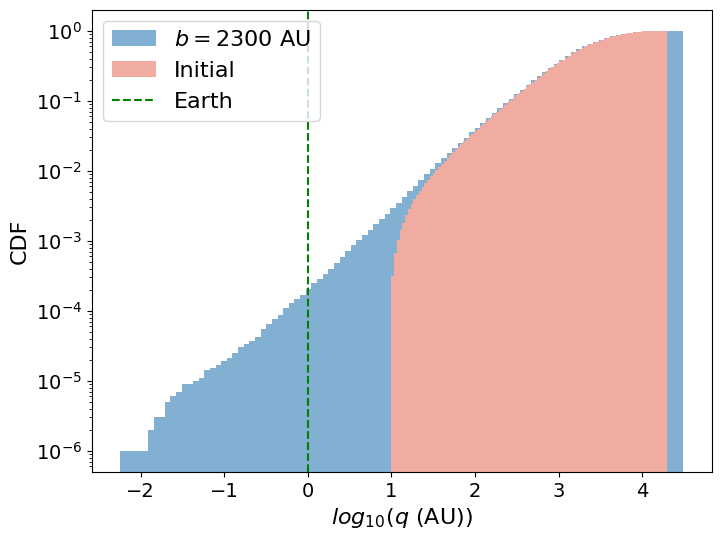

In [45]:
log_q_initial = np.log10(q)
log_q = np.log10(perihelion)
# log_q2 = np.log10(perihelion2)
# log_q3 = np.log10(perihelion3)

R_sun = 0.00465448 # AU

fig, ax = plt.subplots(figsize=(8, 6))


# ax.hist(log_q, bins=100, label='After passage', density=True, cumulative=True, color='black', alpha=0.5)
ax.hist(log_q[log_q>np.log10(R_sun)], bins=100, label=r'$b=2300~\mathrm{AU}$', density=True, cumulative=True, color='#82B0D2')
# ax.hist(log_q2, bins=100, label=r'$b=6394~\mathrm{AU}$', density=True, cumulative=True, color='#C477B2')
# ax.hist(log_q3, bins=100, label=r'$b=12376~\mathrm{AU}$', density=True, cumulative=True, color='#FA7F6F')

ax.hist(log_q_initial, bins=100, label='Initial', density=True, cumulative=True, color='#F0ACA0')

ax.axvline(0, color='green', label='Earth', linestyle='--')
ax.set_xlabel("$log_{10}$($q$ (AU))", fontsize=16)
ax.set_ylabel('CDF', fontsize=16)
ax.set_yscale('log')

ax.legend(fontsize=16)

ax.tick_params(axis='x', labelsize=14)
ax.tick_params(axis='y', labelsize=14)

filtered_log_q = log_q[(log_q < 0)]
filtered_log_q_initial = log_q_initial[(log_q_initial < 0)]

print(f'Number of particles that get into 1 AU: {len(filtered_log_q)} in {N_sim_points} particles')
print(f'Percentage of particles that get into 1 AU: {len(filtered_log_q) / N_sim_points * 100}%')

print(f'Number of particles that get into 1 AU: {len(filtered_log_q_initial)} in {N_sim_points} particles')
print(f'Percentage of particles that get into 1 AU: {len(filtered_log_q_initial) / N_sim_points * 100}%')
